This notebook recreates Figure 5a-d and Figure 6a-b from Hall et al 2019.  

Figures 5a-d show the change in the shape of the log first incomplete moment over time.  
Figures 6a-b show the changing proportion of non-neutral clones across different clone sizes.  

First the simulation must be run. This can take 10-20 minutes.  

The plots can then be generated in the subsequent sections.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8, 6]

In [2]:
import sys
sys.path.append('/Users/mh28/PycharmProjects/incom_paper_repo/new_clean_repo/clone-competition-simulation/')
from parameters import Parameters

In [3]:
from useful_functions import incomplete_moment

In [4]:
from FitnessClasses import MutationGenerator, NormalDist

# Run a simulation

In [5]:
# Run the simulation. Can take 10-20 minutes.
np.random.seed(1)
mutation_generator = MutationGenerator(combine_mutations='add', 
                                       mutation_distribution=NormalDist(std=0.1, mean=1.1),  
                                       synonymous_proportion=0.99)
division_rate = 0.033
mutation_rate = 0.015

max_time = 3000
grid_size = 500
num_cells = grid_size**2
p = Parameters(algorithm='Moran2D', mutation_generator=mutation_generator, 
                  initial_cells=num_cells, progress=500000,
                  division_rate=division_rate, max_time=max_time, mutation_rate=mutation_rate, 
                  samples=10)
sim = p.get_simulator()
sim.run_sim()
sim.unsparsify()

============== Setting up ==============
Using a grid of 500x500
24750000 simulation_steps
371390 mutations to add
Steps completed:
500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000, 4000000, 4500000, 5000000, 5500000, 6000000, 6500000, 7000000, 7500000, 8000000, 8500000, 9000000, 9500000, 10000000, 10500000, 11000000, 11500000, 12000000, 12500000, 13000000, 13500000, 14000000, 14500000, 15000000, 15500000, 16000000, 16500000, 17000000, 17500000, 18000000, 18500000, 19000000, 19500000, 20000000, 20500000, 21000000, 21500000, 22000000, 22500000, 23000000, 23500000, 24000000, 24500000, Finished 24750000 steps


# Incomplete moment over time

Figure 5

In [6]:
# Need a function to fit to the smallest 75% of the visible section
def fit_straight_line_to_incomplete_moment(log_incom, x_range, fix_intercept=True):
    """The intercept we refer to here is when x=min_clone_size since this is the point we want to fix
    We therefore will shift over the values by one to fit, then shift back to plot

    incom will already be from clone size min_clone_size as the first entry
    """
    # Force zero intercept
    log_incom = log_incom - log_incom[0]
    
    slope = np.linalg.lstsq(np.vstack([x_range]).T, log_incom, rcond=None)[0]

    return slope

In [7]:
def get_fitting_section(csd, fit_prop):
    """Find the clone size for which the cumulative total contains fit_prop of the total clones"""
    csd[0] = 0  # Ensure we don't count clones of size zero
    norm_csd = csd/csd.sum()
    cumprop = np.cumsum(norm_csd)
    ind = np.nonzero(cumprop > fit_prop)[0][0]+1  # The index after the last one we want
    print('fitting to first', ind, 'values out of', len(csd))
    return ind

In [8]:
times = [1200, 1800, 2400, 3000]

In [9]:
clone_size_dists = [sim.get_mutant_clone_size_distribution(t) for t in times]

In [10]:
incoms = [incomplete_moment(c) for c in clone_size_dists]

In [11]:
min_size = 100
fit_prop = 0.75
incom = incoms[0]

def plot_fit_to_visible_section(index, min_size, fit_prop):
    incom = incoms[index]
    
    plot_csd = clone_size_dists[index].copy()
    plot_csd[:min_size] = 0 
    plot_x = np.arange(min_size, len(incom))


    fit_section = get_fitting_section(plot_csd, fit_prop=fit_prop)
    fit_incom = incom[min_size:fit_section]
    log_fit_incom = np.log(fit_incom)

    fit_x = np.arange(len(log_fit_incom))
    slope = fit_straight_line_to_incomplete_moment(log_fit_incom, fit_x)
    intercept = log_fit_incom[0]

    y = np.exp(slope * (plot_x - min_size) + intercept)  # Take exp because was fit to the log.
    plt.plot(plot_x, y, 'r--')

    plt.plot(range(min_size, len(incom)), incom[100:], 'k')
    plt.plot(range(1, min_size), incom[1:min_size], 'k', alpha=0.3)
    plt.yscale('log')
    ylim = plt.gca().get_ylim()
    plt.vlines(min_size, 0.0001, 2, linestyle='--', linewidth=1)
    plt.ylim(ylim)
    plt.xlim(left=0);

23 years
fitting to first 219 values out of 315


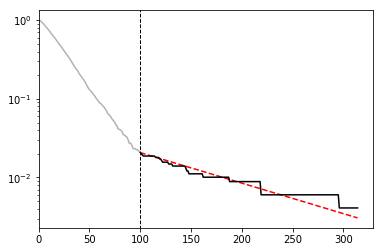

34 years
fitting to first 185 values out of 789


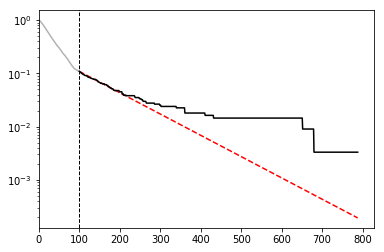

46 years
fitting to first 264 values out of 1498


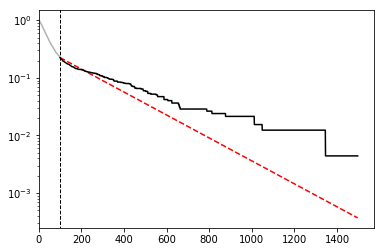

57 years
fitting to first 280 values out of 2362


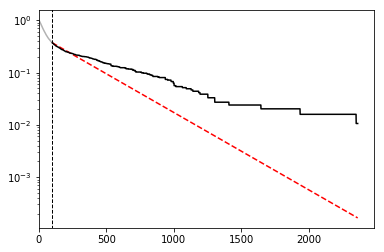

In [12]:
for i, t in enumerate(times):
    print(int(t/52), 'years')
    plot_fit_to_visible_section(i, min_size=100, fit_prop=0.75)
    plt.show()

# Proportion of non-neutral clone at different size ranges

Figure 6 a, b

In [13]:
colours = ['#b2182b','#ef8a62','#fddbc7','#d1e5f0','#67a9cf','#2166ac'][::-1]
thresholds = [50, 100, 200, 400, 800]

In [14]:
# Selection 's'=synonymous, 'ns'=non-synonymous
neutral_clone_sizes = sim.get_mutant_clone_sizes(selection='s', non_zero_only=True)  
non_neutral_clone_sizes = sim.get_mutant_clone_sizes(selection='ns', non_zero_only=True)
neutral_clone_sizes = np.sort(neutral_clone_sizes)
non_neutral_clone_sizes = np.sort(non_neutral_clone_sizes)

In [15]:
neutral_counts = []
non_neutral_counts = []
last_threshold = 0
for t in thresholds:
    neutral_list = [n for n in neutral_clone_sizes if last_threshold <= n < t]
    non_neutral_list = [n for n in non_neutral_clone_sizes if last_threshold <= n < t]
    neutral_counts.append(len(neutral_list))
    non_neutral_counts.append(len(non_neutral_list))
    last_threshold = t
    
neutral_counts.append(len([n for n in neutral_clone_sizes if last_threshold <= n]))
non_neutral_counts.append(len([n for n in non_neutral_clone_sizes if last_threshold <= n]))

In [16]:
non_neutral_proportions = [nn/(n+nn) for (n, nn) in zip(neutral_counts, non_neutral_counts)]

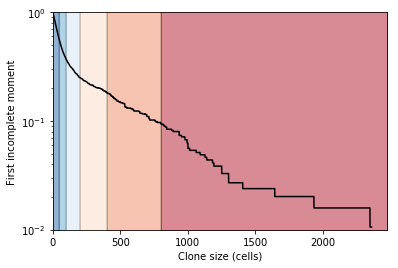

In [17]:
incom = incoms[-1]
plt.plot(range(len(incom)), incom, 'k')
plt.vlines(thresholds, 0.001, 1, linewidth=0.3)
last_threshold = 0
for t, c in zip(thresholds, colours):
    plt.fill_betweenx([0.01, 1], last_threshold, t, alpha=0.5, color=c)
    last_threshold = t
xlim = plt.gca().get_xlim()
plt.fill_betweenx([0.01, 1], last_threshold, xlim[1], alpha=0.5, color=colours[-1])

plt.xlim(left=0, right=xlim[1])
plt.ylim(top=1, bottom=0.01)
plt.yscale('log')
plt.xlabel('Clone size (cells)')
plt.ylabel('First incomplete moment');

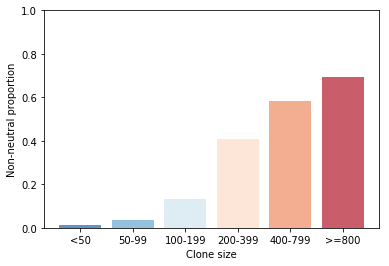

In [18]:
plt.bar(range(len(non_neutral_proportions)), non_neutral_proportions, color=colours, alpha=0.7)
plt.ylabel('Non-neutral proportion')
plt.xlabel('Clone size')
plt.xticks(range(len(non_neutral_proportions)), 
           ['<50', '50-99', '100-199', '200-399', '400-799', '>=800'])
plt.ylim(0, 1);